In [2]:
%run ./Custom_Functions.ipynb

NumPy 1.20.1
Pandas 1.2.4
SciPy 1.6.2
Scikit-Learn 1.0.2
scikit-optimize 0.9.0
Seaborn 0.11.1
Pydot 1.4.2
Pillow Version: 8.2.0
TF version 2.8.0
Keras version 2.8.0
Kerastuner 1.0.3
ray 1.11.0
----------------------------------------------------------------------


In [6]:
# Load TensorBoard Logs (or http://localhost:6006)
%load_ext tensorboard
# %tensorboard --logdir callbacks/logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Pipeline : Baseline SCV -- SM

In [1]:
# Load all libraries and custom functions from another notebook
%run ./Custom_Functions.ipynb
start = time()

path_to_cwd = '/Sylvie_notebooks/DS4' # specify current working dir 

# >> Step 1: load metadata
json_key_path = '\\Sylvie_notebooks\\DS4\\tranquil-lore-342617-05dea4250c64.json'
metadata = load_metadata_from_gcs(json_key_path)

# >> Step 2: load and merge dataset
merged_df = load_and_merge(path_to_cwd)

# >> Step 3: Train/test split
target_col = metadata.columns[-1]
train_df, val_df, test_df = split_df(merged_df, target_col)

# >> Step 4: Data trimming
max_samples = train_df.label.value_counts()[1] # 4809
trim_df = trim(train_df, max_samples, target_col)

# >> Step 5: Data Augmentation (offline)
image_col = trim_df.columns[0]
img_size = (100,100) # or what I want
img_format = metadata.file_format[0]
train_df_balanced = aug_train(trim_df, max_samples, image_col, target_col, img_size, img_format, path_to_cwd)

# >> Step 6: Convert aug_train_df into X_train, y_train arrays
X_train = img_from_df_to_array(img_col=train_df_balanced.file_path)
y_train = train_df_balanced.label
print_in_color(f'\nX_train shape: {X_train.shape} \ny_train shape: {y_train.shape}\n',(255,0,255),(55,65,80))

# >> Step 7: Convert val_df into X_val and y_val arrays, rezise and rescale
X_val = img_from_df_to_array(img_col=val_df.file_path)
y_val = val_df.label
print_in_color(f'\nX_val shape: {X_val.shape} \ny_val shape: {y_val.shape}\n',(255,0,255),(55,65,80))

# >> Step 8: Flatten images into 2D array
X_train = X_train.reshape((len(X_train), -1))
X_val = X_val.reshape((len(X_val), -1))

# >> Step 8: Encode target to 1D array
y_train = LabelEncoder().fit_transform(y_train)
y_val = LabelEncoder().fit_transform(y_val)
print_in_color(f'\nShape of X_train and y_train after flattening and encoding:',(0,255,255),(55,65,80))
print(f'X_train shape: {X_train.shape}\ny_train shape:{y_train.shape}')
print_in_color(f'\nShape of X_val and y_val after flattening and encoding:',(0,255,255),(55,65,80))
print(f'X_val shape: {X_val.shape}\ny_val shape:{y_val.shape}\n')

# >> Step 9: Train model with BayesSearchCV
cv = 3 
n_iter = 10 
n_points = 10 # num settings in parallel
search_results = train_svc_hpo(X_train, y_train, cv=cv, n_iter=n_iter, n_points=n_points)


# >> Step 10: Evaluate Baseline model
baseline_results_df = evaluate_baseline(search_results, X_train, y_train, X_val, y_val)


# Total pipeline duration
baseline_tuned_SM = (time()-start)/60 # 320 min (10K)
print_in_color(f'\nElasped time for the entire "baseline_tuned_SM" : {baseline_tuned_SM:.2f} min',(0,255,0),(55,65,80))
%chime

NumPy 1.20.1
Pandas 1.2.4
SciPy 1.6.2
Scikit-Learn 1.0.2
scikit-optimize 0.9.0
Seaborn 0.11.1
Pydot 1.4.2
Pillow Version: 8.2.0
TF version 2.8.0
Keras version 2.8.0
Kerastuner 1.0.3
----------------------------------------------------------------------

The shape of the merged_df is:
 (21165, 2)

After the split, listed below are the number of images in each set:


    Images in the training set: 	16932
    Images in the validation set: 	2116
    Images in the test set: 		2117
    

Original number of images in train_df:

16932

Number of images per Class in train_df

Normal             8154
Lung_Opacity       4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64

Number of images trimmed from the majority Class:

3345

Number of images per Class in trim_df

Lung_Opacity       4809
Normal             4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64

Total number of images in trim_df:

13587 



  0%|          | 0/4 [00:00<?, ?it/s]

Found 1076 validated image filenames.
Found 2893 validated image filenames.

Total images created in the aug_img folder:

5649 augmented images created

Number of images per Class in the trim_df before augmentation:

Lung_Opacity       4809
Normal             4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64 

Number of images per Class in the train_df_balanced after augmentation:

COVID              4809
Viral_Pneumonia    4809
Lung_Opacity       4809
Normal             4809
Name: label, dtype: int64 

Total number of images in train_df_balanced:

19236 


Original and augmented images converted to numpy array:

All images are now in <class 'numpy.ndarray'>
Number of images = 19236
Shape of images: (19236, 100, 100, 1)

X_train shape: (19236, 100, 100, 1) 
y_train shape: (19236,)



Original and augmented images converted to numpy array:

All images are now in <class 'numpy.ndarray'>
Number of images = 2116
Shape of images: (2116, 100, 100, 1)

X_val shape

Accuracy_train  Accuracy_val  Recall_train  \
Baseline SVC model (SM)             1.0      0.801154           1.0   

                         Recall_val  Loss_train  Loss_val  
Baseline SVC model (SM)    0.812208           0         0


Elasped time for the entire "baseline_tuned_SM" : 927.13 min



In [2]:
from sklearn.model_selection import learning_curve

# Define model
model = search_results.best_estimator_

# Settings
plt.figure(figsize=(10,5))
cv=10 # number of folds for StratifiedKFold()
sizes = np.linspace(start=0.05, stop=1.0, num=10) # start@beginning(5%), stop@end(100%)show all pts, 10 pts/curve  

# Split the entire dataset into train/val
train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, scoring='accuracy', cv=cv, train_sizes=sizes, n_jobs=-1) 

# Calculate train and test mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

<Figure size 720x360 with 0 Axes>

(0.6, 1.05)

Text(0.5, 0, 'Training sample size')

Text(0, 0.5, 'Model Accuracy')

Text(0.5, 1.0, 'Learning Curves')

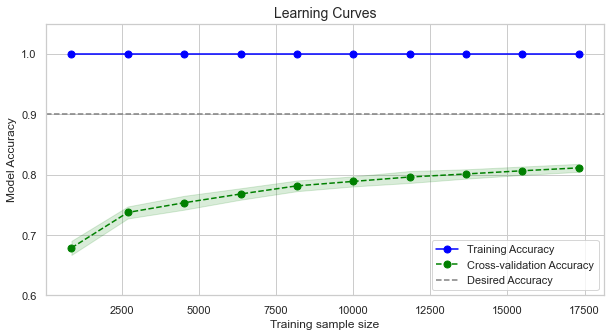


Training Accuracy: 1.0
Cross-Validation Accuracy: 0.811



In [21]:
# Plot the learning curve

plt.figure(figsize=(10,5))
# Plot learning curves
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=7, label='Training Accuracy')
plt.plot(train_sizes, val_mean, color='green', marker='o', markersize=7, linestyle='--', label='Cross-validation Accuracy')
plt.axhline(y=0.9, linestyle='--', color='grey', label='Desired Accuracy')  

# Add Std dev
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.15, color='green')

# Settings
plt.ylim(0.6,1.05)
plt.xlabel('Training sample size')
plt.ylabel('Model Accuracy')
plt.title('Learning Curves', fontsize=14)
plt.legend(loc='best')
plt.show()

# Print accuracy at the end of learning
print(f'\nTraining Accuracy: {round((train_scores[9].mean()),3)}')
print(f'Cross-Validation Accuracy: {round((val_scores[9].mean()),3)}\n')

# Pipeline : Untuned basic -- SM

NumPy 1.20.1
Pandas 1.2.4
SciPy 1.6.2
Scikit-Learn 1.0.2
scikit-optimize 0.9.0
Seaborn 0.11.1
Pydot 1.4.2
Pillow Version: 8.2.0
TF version 2.8.0
Keras version 2.8.0
Kerastuner 1.0.3
ray 1.11.0
----------------------------------------------------------------------

The shape of the merged_df is:
 (21165, 2)

After the split, listed below are the number of images in each set:


    Images in the training set: 	16932
    Images in the validation set: 	2116
    Images in the test set: 		2117
    

Original number of images in train_df:

16932

Number of images per Class in train_df

Normal             8154
Lung_Opacity       4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64

Number of images trimmed from the majority Class:

3345

Number of images per Class in trim_df

Lung_Opacity       4809
Normal             4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64

Total number of images in trim_df:

13587 



  0%|          | 0/4 [00:00<?, ?it/s]

Found 2893 validated image filenames.
Found 1076 validated image filenames.

Total images created in the aug_img folder:

5649 augmented images created

Number of images per Class in the trim_df before augmentation:

Lung_Opacity       4809
Normal             4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64 

Number of images per Class in the train_df_balanced after augmentation:

COVID              4809
Viral_Pneumonia    4809
Lung_Opacity       4809
Normal             4809
Name: label, dtype: int64 

Total number of images in train_df_balanced:

19236 

Found 19236 validated image filenames belonging to 4 classes.

Number of images in the balanced train_generator:

19236

List of classes in the train_generator:

['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']

Few examples of OHE labels in the train_generator:

[1, 1, 0, 2, 2, 0, 0, 1, 3, 3, 1, 2, 3, 2, 3, 0, 0, 3, 2, 1] 

Found 2116 validated image filenames belonging to 4 classes.

val_generator

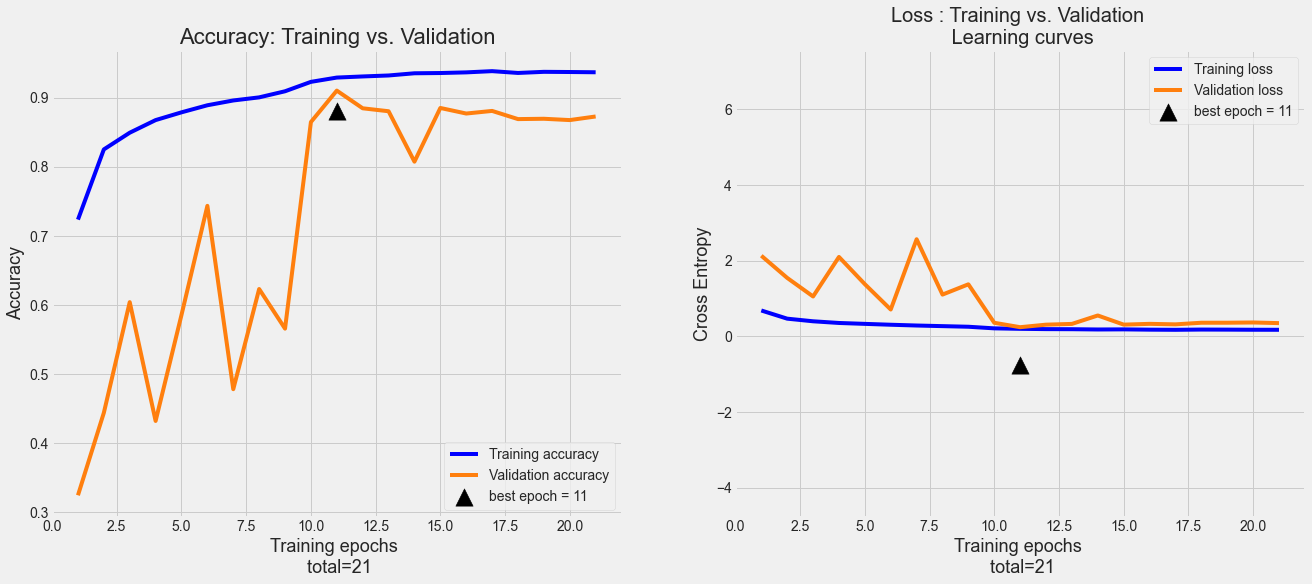

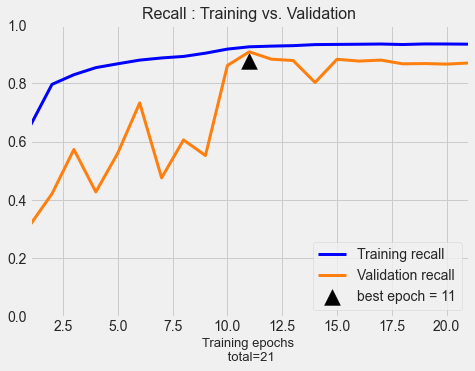

In [1]:
# Load all libraries and custom functions from another notebook
%run ./Custom_Functions.ipynb
path_to_cwd = '/Sylvie_notebooks/DS4' 
start = time()

# >> Step 1: load metadata
json_key_path = '\\Sylvie_notebooks\\DS4\\tranquil-lore-342617-05dea4250c64.json'
metadata = load_metadata_from_gcs(json_key_path) 

# >> Step 2: load and merge dataset
merged_df = load_and_merge(path_to_cwd)

# >> Step 3: Train/test split
target_col = metadata.columns[-1]
train_df, val_df, test_df = split_df(merged_df, target_col)

# >> Step 4: Data trimming
max_samples = train_df.label.value_counts()[1] # 4809
trim_df = trim(train_df, max_samples, target_col)

# >> Step 5: Data Augmentation (offline)
image_col = trim_df.columns[0]
img_size = (100,100) # or what I want
img_format = metadata.file_format[0]
train_df_balanced = aug_train(trim_df, max_samples, image_col, target_col, img_size, img_format, path_to_cwd)

# >> Step 6: Train Generator: Data Augmentation (on-the-fly)
batch_size = 64
img_np = metadata.image_data_grayscale
num_channels = img_np.shape[-1] if img_np.ndim == 3 else 1
img_shape = (img_size[0], img_size[1], num_channels)
train_generator = train_gen(train_df_balanced,image_col,target_col,img_format,img_size,img_shape,num_channels,batch_size)

# >> Step 7: Val Generator: Rescale and Resize only
val_generator = val_gen(val_df,image_col,target_col,img_format,img_size,img_shape,num_channels,batch_size) 

# >> Step 8: Define callbacks
callback_hpo, callback_training = callbacks(path_to_cwd, name='untuned_SM')

# >> Step 9: Create model
model = create_cnn()

# # >> Step 10: Fit model
epochs = 50  # 50
model, history = train_model_gen(model, train_generator, val_generator, epochs)

# >> Step 11: Save model
model_name = 'untuned_basic_SM'
save_model_gen(model, model_name, train_generator, img_size, path_to_cwd, pixel_scaler=255)

# >> Step 12: Evaluate basic model
model_name = 'Untuned basic Model (SM)'
name = 'untuned'
untuned_results_df =  metrics_train_val(history, model_name, name, index_name='Untuned Basic (SM)') # save results

# Total pipeline duration
pipeline_untuned_SM = (time()-start)/60 # 25 min
print_in_color(f'\nElasped time for the entire "pipeline_untuned_SM" : {pipeline_untuned_SM:.2f} min',(0,255,0),(55,65,80))

# >> Step 13: Plot learning curves and Recall
plot_learning_curve_and_recall(history)
%chime

# Pipeline: Tuned model -- GS -- SM

## 1. Data prep

In [1]:
# Load all libraries and custom functions from another notebook
%run ./Custom_Functions.ipynb
start = time()

path_to_cwd = '/Sylvie_notebooks/DS4' # specify current working dir 

# >> Step 1: load metadata
json_key_path = '\\Sylvie_notebooks\\DS4\\tranquil-lore-342617-05dea4250c64.json'
metadata = load_metadata_from_gcs(json_key_path)


# >> Step 2: load and merge dataset
merged_df = load_and_merge(path_to_cwd)

# >> Step 3: Train/test split
target_col = metadata.columns[-1]
train_df, val_df, test_df = split_df(merged_df, target_col)

# >> Step 4: Data trimming
max_samples = train_df.label.value_counts()[1] # 4809
trim_df = trim(train_df, max_samples, target_col)

# >> Step 5: Data Augmentation (offline)
image_col = trim_df.columns[0]
img_size = (100,100) # or what I want
img_format = metadata.file_format[0]
train_df_balanced = aug_train(trim_df, max_samples, image_col, target_col, img_size, img_format, path_to_cwd)

# >> Step 6: Convert aug_train_df into array
X_train = img_from_df_to_array(img_col=train_df_balanced.file_path)
y_train = tf.keras.utils.to_categorical(y=train_df_balanced.label.factorize()[0])
print_in_color(f'\nX_train shape: {X_train.shape} \ny_train shape: {y_train.shape}\n',(255,0,255),(55,65,80))

# >> Step 7: Train Generator: Data Augmentation (on-the-fly)
batch_size = 64
img_np = metadata.image_data_grayscale
num_channels = img_np.shape[-1] if img_np.ndim == 3 else 1
img_shape = (img_size[0], img_size[1], num_channels)
train_generator = train_gen(train_df_balanced,image_col,target_col,img_format,img_size,img_shape,num_channels,batch_size)

# >> Step 8: Val Generator: Rescale and Resize only
val_generator = val_gen(val_df,image_col,target_col,img_format,img_size,img_shape,num_channels,batch_size) 

# >> Step 9: Convert val generator into array
X_val = np.concatenate([val_generator.next()[0] for i in range(val_generator.__len__())])
y_val = np.concatenate([val_generator.next()[1] for i in range(val_generator.__len__())])
print_in_color('\nValidation data from val_generator after conversion to numpy array:',(0,255,255),(55,65,80))
print_in_color(f'\nX_val shape: {X_val.shape} \ny_val shape: {y_val.shape}\n',(255,0,255),(55,65,80))

# >> Step 10: Define callbacks
callback_hpo, callback_training = callbacks(path_to_cwd, name='GS_SM')

NumPy 1.20.1
Pandas 1.2.4
SciPy 1.6.2
Scikit-Learn 1.0.2
scikit-optimize 0.9.0
Seaborn 0.11.1
Pydot 1.4.2
Pillow Version: 8.2.0
TF version 2.8.0
Keras version 2.8.0
Kerastuner 1.0.3
ray 1.11.0
----------------------------------------------------------------------

The shape of the merged_df is:
 (21165, 2)

After the split, listed below are the number of images in each set:


    Images in the training set: 	16932
    Images in the validation set: 	2116
    Images in the test set: 		2117
    

Original number of images in train_df:

16932

Number of images per Class in train_df

Normal             8154
Lung_Opacity       4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64

Number of images trimmed from the majority Class:

3345

Number of images per Class in trim_df

Normal             4809
Lung_Opacity       4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64

Total number of images in trim_df:

13587 



  0%|          | 0/4 [00:00<?, ?it/s]

Found 1076 validated image filenames.
Found 2893 validated image filenames.

Total images created in the aug_img folder:

5649 augmented images created

Number of images per Class in the trim_df before augmentation:

Normal             4809
Lung_Opacity       4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64 

Number of images per Class in the train_df_balanced after augmentation:

Normal             4809
Lung_Opacity       4809
COVID              4809
Viral_Pneumonia    4809
Name: label, dtype: int64 

Total number of images in train_df_balanced:

19236 


Original and augmented images converted to numpy array:

All images are now in <class 'numpy.ndarray'>
Number of images = 19236
Shape of images: (19236, 100, 100, 1)

X_train shape: (19236, 100, 100, 1) 
y_train shape: (19236, 4)


Found 19236 validated image filenames belonging to 4 classes.

Number of images in the balanced train_generator:

19236

List of classes in the train_generator:

['COVID', 'Lu

## 2. Model tuning & training

In [3]:
# >> Step 11: Create KerasClassifer Wrapper and start GridSearch
epochs = 1    # going through the entire dataset once
cv = 3    # default: StratifiedKFold
grid_results = kerasclassifier_GS(cnn_model_gs, cv, epochs) # X_train, y_train, X_val, y_val

# >> Step 12: Print best HP results
best_hps = grid_cv_results(grid_results)

# >> Step 13: Fit best_model_GS
epochs = 50  
model = grid_results.best_estimator_.model 
model, history = train_model_gen(model, train_generator, val_generator, epochs)
%chime

## 3. Model evaluation

In [ ]:
# >> Step 14: Evaluate best_model_GS
model_name = 'Tuned_GS CNN Model'
name = 'GS'
GS_results_df =  metrics_train_val(history, model_name, name, index_name='GridSearch (SM)') # save results

# >> Step 15: Save model
model_name='best_tuned_GS_SM'
save_model_gen(model, model_name, train_generator, img_size, path_to_cwd, pixel_scaler=255)

# Total pipeline duration
pipeline_kerasClassifier_GS_SM = (time()-start)/60 # 15 min
print_in_color(f'\nElasped time for the entire "pipeline_kerasClassifier_GS_SM" : {pipeline_kerasClassifier_GS_SM:.2f} min',(0,255,0),(55,65,80))

# >> Step 16: Plot Learning Curve and Recall
plot_learning_curve_and_recall(history)

# Pipeline : Tuned model -- RS -- SM

## 1. Data prep

In [45]:
# Load all libraries and custom functions from another notebook
%run ./Custom_Functions.ipynb
start = time()

path_to_cwd = '/Sylvie_notebooks/DS4' # specify current working dir 

# >> Step 1: load metadata
json_key_path = '\\Sylvie_notebooks\\DS4\\tranquil-lore-342617-05dea4250c64.json'
metadata = load_metadata_from_gcs(json_key_path)

# >> Step 2: load and merge dataset
merged_df = load_and_merge(path_to_cwd)

# >> Step 3: Train/test split
target_col = metadata.columns[-1]
train_df, val_df, test_df = split_df(merged_df, target_col)

# >> Step 4: Data trimming
max_samples = train_df.label.value_counts()[1] # 4809
trim_df = trim(train_df, max_samples, target_col)

# >> Step 5: Data Augmentation (offline)
image_col = trim_df.columns[0]
img_size = (100,100) # or what I want
img_format = metadata.file_format[0]
train_df_balanced = aug_train(trim_df, max_samples, image_col, target_col, img_size, img_format, path_to_cwd)

# >> Step 6: Train Generator: Data Augmentation (on-the-fly)
batch_size = 64
image_col = train_df_balanced.columns[0]
img_size = (100,100) # the max with my GPU
img_format = metadata.file_format[0]
img_np = metadata.image_data_grayscale
num_channels = img_np.shape[-1] if img_np.ndim == 3 else 1
img_shape = (img_size[0], img_size[1], num_channels)
train_generator = train_gen(train_df_balanced,image_col,target_col,img_format,img_size,img_shape,num_channels,batch_size)

# >> Step 7: Val Generator: Rescale and Resize only
val_generator = val_gen(val_df,image_col,target_col,img_format,img_size,img_shape,num_channels,batch_size) 

# >> Step 8: Define callbacks
callback_hpo, callback_training = callbacks(path_to_cwd, name='RS_SM')

NumPy 1.20.1
Pandas 1.2.4
SciPy 1.6.2
The chime extension is already loaded. To reload it, use:
  %reload_ext chime
Scikit-Learn 1.0.2
scikit-optimize 0.9.0
Seaborn 0.11.1
Pydot 1.4.2
Pillow Version: 8.2.0
TF version 2.8.0
Keras version 2.8.0
Kerastuner 1.0.3
ray 1.11.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
----------------------------------------------------------------------

The shape of the merged_df is:
 (21165, 2)

After the split, listed below are the number of images in each set:


    Images in the training set: 	16932
    Images in the validation set: 	2116
    Images in the test set: 		2117
    

Original number of images in train_df:

16932

Number of images per Class in train_df

Normal             8154
Lung_Opacity       4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64

Number of images trimmed from the majority Class:

3345

Number of images per Class in trim_df

Lung_Opacity       4809
Nor

  0%|          | 0/4 [00:00<?, ?it/s]

Found 2893 validated image filenames.
Found 1076 validated image filenames.

Total images created in the aug_img folder:

5649 augmented images created

Number of images per Class in the trim_df before augmentation:

Lung_Opacity       4809
Normal             4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64 

Number of images per Class in the train_df_balanced after augmentation:

Lung_Opacity       4809
Viral_Pneumonia    4809
COVID              4809
Normal             4809
Name: label, dtype: int64 

Total number of images in train_df_balanced:

19236 

Found 19236 validated image filenames belonging to 4 classes.

Number of images in the balanced train_generator:

19236

List of classes in the train_generator:

['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']

Few examples of OHE labels in the train_generator:

[3, 3, 3, 1, 0, 3, 2, 1, 1, 1, 1, 3, 2, 3, 2, 0, 0, 2, 1, 2] 

Found 2116 validated image filenames belonging to 4 classes.

val_generator

## 2. Model tuning & training

In [46]:
# >> Step 9: Keras-Tuner RandomSearch
epochs = 3    # similar to cv=3
max_trials = 20 # number of hp combination to test
tuner = kerastuner_RS(kerastuner_cnn_model, max_trials, epochs, path_to_cwd)

# >> Step 10: Print best HP results
tuner_type = 'RandomSearch'
best_hps = kerastuner_results(tuner, tuner_type=tuner_type)

# >> Step 11: Re-build the model using the best HP
model = tuner.hypermodel.build(best_hps)
get_kerastuner_structure(tuner, tuner_type=tuner_type) # show model structure

# >> Step 12: Fit model
epochs = 50  # 50
model, history = train_model_gen(model, train_generator, val_generator, epochs)
%chime

Trial 20 Complete [00h 03m 12s]
val_accuracy: 0.5992438793182373

Best val_accuracy So Far: 0.5992438793182373
Total elapsed time: 01h 03m 56s
INFO:tensorflow:Oracle triggered exit

Optimal hyperparameters with RandomSearch:


    Number of filters in input layer 	32

    Number of Conv2D layer(s) 		4
    Number of Dense layer(s) 		3
    Dropout 				0.1

    
The hyperparameter search is complete. 
List of all best hyperparameters with RandomSearch:

{'dropout_rate': 0.1,
 'n_filters_conv_2': 128,
 'n_filters_conv_3': 128,
 'n_filters_conv_4': 256,
 'n_filters_conv_5': 128,
 'n_filters_conv_6': 64,
 'n_filters_input': 32,
 'n_layers_conv': 4,
 'n_layers_dense': 3,
 'n_nodes_dense_1': 192,
 'n_nodes_dense_2': 192,
 'n_nodes_dense_3': 192,
 'n_nodes_dense_4': 128,
 'pooling_conv_2': 'avg',
 'pooling_conv_3': 'max',
 'pooling_conv_4': 'max',
 'pooling_conv_5': 'avg',
 'pooling_conv_6': 'max'}
------------------------------------------------------------

Architecture of the best model with


Model training using the best hyperparameters started...

Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 0.6734 - accuracy: 0.7243 - recall: 0.6649
Epoch 1: val_loss improved from inf to 1.92962, saving model to /Sylvie_notebooks/DS4\callbacks\RS_SM_best_weights-ep01-loss1.93.hdf5

val/train loss ratio: 2.87

300/300 [==============================] - 71s 231ms/step - loss: 0.6734 - accuracy: 0.7243 - recall: 0.6649 - val_loss: 1.9296 - val_accuracy: 0.3509 - val_recall: 0.3414 - lr: 0.0020
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 0.4589 - accuracy: 0.8202 - recall: 0.7945
Epoch 2: val_loss did not improve from 1.92962

val/train loss ratio: 8.92

300/300 [==============================] - 68s 227ms/step - loss: 0.4589 - accuracy: 0.8202 - recall: 0.7945 - val_loss: 4.0955 - val_accuracy: 0.2694 - val_recall: 0.2666 - lr: 0.0020
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 0.3880 - accuracy: 0.8513 - recall: 

## 3. Model evaluation


Performance Metrics from best_epoch for 
	"Tuned_RS_SM CNN Model"	


    Train Accuracy: 		94.6%
    Validation Accuracy: 	90.8%
    Train Recall: 		0.94
    Validation Recall: 		0.91
    Train Loss: 		0.14
    Validation Loss: 		0.27
    

The entire model was saved in the saved_models folder as:

best_tuned_RS_SM.h5

Class file was saved in the saved_models folder as:

class_df_best_tuned_RS_SM_model.csv 

Elasped time for the entire "pipeline_kerasTuner_RS_SM" : 95.48 min


--------------- Learning Curves and Recall ---------------

 Best epoch = 17 



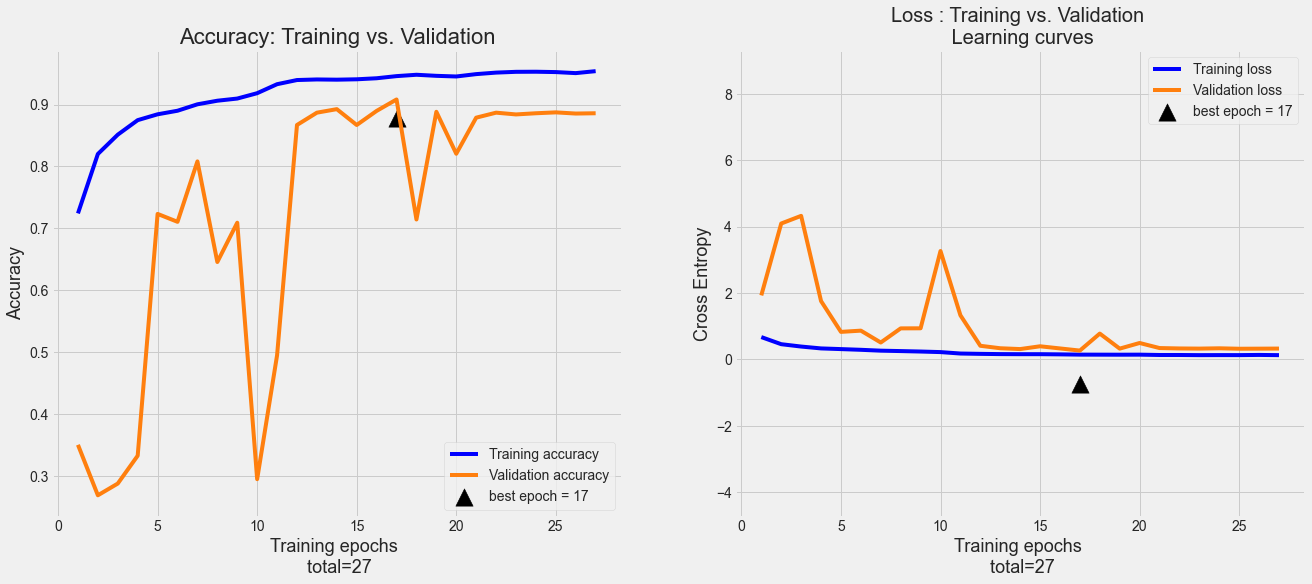

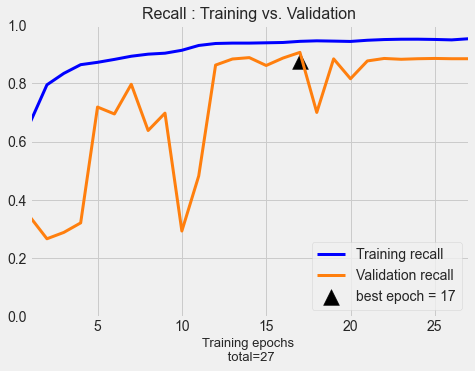

In [47]:
# >> Step 13: Evaluate tuned_RS model
model_name = 'Tuned_RS_SM CNN Model'
name = 'RS'
RS_results_df =  metrics_train_val(history, model_name, name, index_name='RandomSearch (SM)') # save results

# >> Step 14: Save model
model_name = 'best_tuned_RS_SM'
save_model_gen(model, model_name, train_generator, img_size, path_to_cwd, pixel_scaler=255)

# Total pipeline duration
pipeline_kerasTuner_RS_SM = (time()-start)/60 # 110 min
print_in_color(f'Elasped time for the entire "pipeline_kerasTuner_RS_SM" : {pipeline_kerasTuner_RS_SM:.2f} min',(0,255,0),(55,65,80))

# >> Step 15: Plot learning curves and Recall
plot_learning_curve_and_recall(history)

# Pipeline: Tuned model -- BS -- SM

## 1. Data prep

In [60]:
# Load all libraries and custom functions from another notebook
%run ./Custom_Functions.ipynb
start = time()
path_to_cwd = '/Sylvie_notebooks/DS4' # specify current working dir 

# >> Step 1: load metadata
json_key_path = '\\Sylvie_notebooks\\DS4\\tranquil-lore-342617-05dea4250c64.json'
metadata = load_metadata_from_gcs(json_key_path)

# >> Step 2: load and merge dataset
merged_df = load_and_merge(path_to_cwd)

# >> Step 3: Train/test split
target_col = metadata.columns[-1]
train_df, val_df, test_df = split_df(merged_df, target_col)

# >> Step 4: Data trimming
max_samples = train_df.label.value_counts()[1] # 4809
trim_df = trim(train_df, max_samples, target_col)

# # >> Step 5: Data Augmentation (offline)
image_col = trim_df.columns[0]
img_size = (100,100) # the max with my GPU
img_format = metadata.file_format[0]
train_df_balanced = aug_train(trim_df, max_samples, image_col, target_col, img_size, img_format, path_to_cwd)

# >> Step 6: Train Generator: Data Augmentation (on-the-fly)
batch_size = 64
img_np = metadata.image_data_grayscale
num_channels = img_np.shape[-1] if img_np.ndim == 3 else 1
img_shape = (img_size[0], img_size[1], num_channels)
train_generator = train_gen(train_df_balanced,image_col,target_col,img_format,img_size,img_shape,num_channels,batch_size)

# >> Step 7: Val Generator: Rescale and Resize only
val_generator = val_gen(val_df,image_col,target_col,img_format,img_size,img_shape,num_channels,batch_size) 

# >> Step 8: Define callbacks
callback_hpo, callback_training = callbacks(path_to_cwd, name='BS_SM')

NumPy 1.20.1
Pandas 1.2.4
SciPy 1.6.2
The chime extension is already loaded. To reload it, use:
  %reload_ext chime
Scikit-Learn 1.0.2
scikit-optimize 0.9.0
Seaborn 0.11.1
Pydot 1.4.2
Pillow Version: 8.2.0
TF version 2.8.0
Keras version 2.8.0
Kerastuner 1.0.3
ray 1.11.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
----------------------------------------------------------------------

The shape of the merged_df is:
 (21165, 2)

After the split, listed below are the number of images in each set:


    Images in the training set: 	16932
    Images in the validation set: 	2116
    Images in the test set: 		2117
    

Original number of images in train_df:

16932

Number of images per Class in train_df

Normal             8154
Lung_Opacity       4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64

Number of images trimmed from the majority Class:

3345

Number of images per Class in trim_df

Lung_Opacity       4809
Nor

  0%|          | 0/4 [00:00<?, ?it/s]

Found 2893 validated image filenames.
Found 1076 validated image filenames.

Total images created in the aug_img folder:

5649 augmented images created

Number of images per Class in the trim_df before augmentation:

Lung_Opacity       4809
Normal             4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64 

Number of images per Class in the train_df_balanced after augmentation:

Lung_Opacity       4809
Viral_Pneumonia    4809
COVID              4809
Normal             4809
Name: label, dtype: int64 

Total number of images in train_df_balanced:

19236 

Found 19236 validated image filenames belonging to 4 classes.

Number of images in the balanced train_generator:

19236

List of classes in the train_generator:

['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']

Few examples of OHE labels in the train_generator:

[2, 1, 2, 3, 3, 3, 0, 3, 1, 2, 1, 1, 3, 2, 3, 2, 1, 2, 2, 1] 

Found 2116 validated image filenames belonging to 4 classes.

val_generator

## 2. Model tuning & training

In [61]:
# >> Step 9: Keras-Tuner BayesSearch
epochs = 3    # similar to cv=3
max_trials = 20  
tuner = kerastuner_BS(kerastuner_cnn_model, max_trials, path_to_cwd)

# >> Step 10: Print best HP results
tuner_type = 'BayesSearch'
best_hps = kerastuner_results(tuner, tuner_type=tuner_type)

# >> Step 11: Re-build the model using the best HP
model = tuner.hypermodel.build(best_hps)
get_kerastuner_structure(tuner, tuner_type=tuner_type) # show model structure

# >> Step 12: Fit model
epochs = 50   
model, history = train_model_gen(model, train_generator, val_generator, epochs) 
%chime

Trial 20 Complete [00h 03m 38s]
val_accuracy: 0.6691871285438538

Best val_accuracy So Far: 0.7235350012779236
Total elapsed time: 01h 27m 30s
INFO:tensorflow:Oracle triggered exit

Optimal hyperparameters with BayesSearch:


    Number of filters in input layer 	96

    Number of Conv2D layer(s) 		3
    Number of Dense layer(s) 		3
    Dropout 				0.30000000000000004

    
The hyperparameter search is complete. 
List of all best hyperparameters with BayesSearch:

{'dropout_rate': 0.30000000000000004,
 'n_filters_conv_2': 128,
 'n_filters_conv_3': 64,
 'n_filters_conv_4': 64,
 'n_filters_conv_5': 256,
 'n_filters_conv_6': 256,
 'n_filters_input': 96,
 'n_layers_conv': 3,
 'n_layers_dense': 3,
 'n_nodes_dense_1': 64,
 'n_nodes_dense_2': 256,
 'n_nodes_dense_3': 256,
 'n_nodes_dense_4': 256,
 'pooling_conv_2': 'max',
 'pooling_conv_3': 'avg',
 'pooling_conv_4': 'max',
 'pooling_conv_5': 'max',
 'pooling_conv_6': 'avg'}
------------------------------------------------------------

Archite


Model training using the best hyperparameters started...

Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 0.8895 - accuracy: 0.6225 - recall: 0.5261
Epoch 1: val_loss improved from inf to 3.01729, saving model to /Sylvie_notebooks/DS4\callbacks\BS_SM_best_weights-ep01-loss3.02.hdf5

val/train loss ratio: 3.39

300/300 [==============================] - 78s 251ms/step - loss: 0.8895 - accuracy: 0.6225 - recall: 0.5261 - val_loss: 3.0173 - val_accuracy: 0.2841 - val_recall: 0.2841 - lr: 0.0020
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 0.6642 - accuracy: 0.7314 - recall: 0.6690
Epoch 2: val_loss improved from 3.01729 to 1.71835, saving model to /Sylvie_notebooks/DS4\callbacks\BS_SM_best_weights-ep02-loss1.72.hdf5

val/train loss ratio: 2.59

300/300 [==============================] - 73s 243ms/step - loss: 0.6642 - accuracy: 0.7314 - recall: 0.6690 - val_loss: 1.7184 - val_accuracy: 0.4740 - val_recall: 0.4692 - lr: 0.0020
Epoch 3/50
300/

## 3. Model evaluation


Performance Metrics from best_epoch for 
	"Tuned_BS_SM CNN Model"	


    Train Accuracy: 		89.5%
    Validation Accuracy: 	84.6%
    Train Recall: 		0.88
    Validation Recall: 		0.84
    Train Loss: 		0.29
    Validation Loss: 		0.43
    

The entire model was saved in the saved_models folder as:

best_tuned_BS_SM.h5

Class file was saved in the saved_models folder as:

class_df_best_tuned_BS_SM_model.csv 


Elasped time for the entire "pipeline_kerasTuner_BS_SM" : 123.07 min


--------------- Learning Curves and Recall ---------------

 Best epoch = 17 



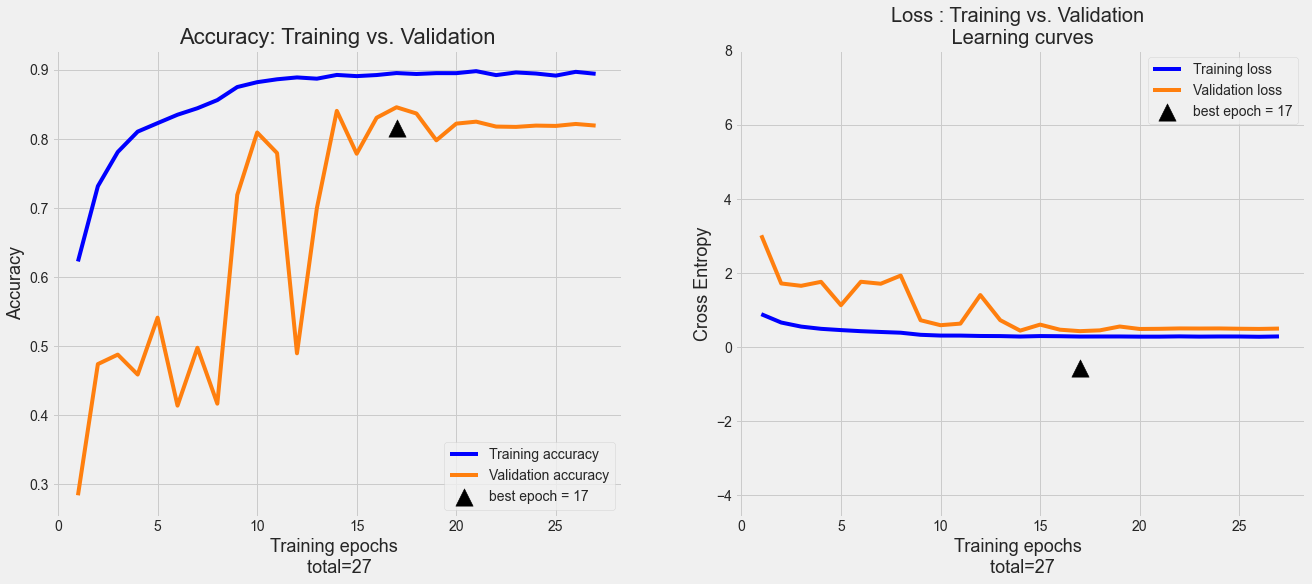

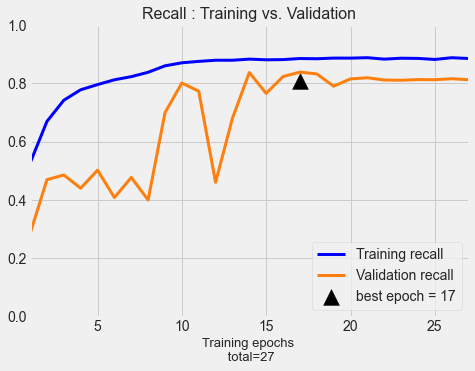

In [62]:
# >> Step 13: Evaluate tuned_BS model
model_name = 'Tuned_BS_SM CNN Model'
name = 'BS'
BS_results_df =  metrics_train_val(history, model_name, name, index_name='BayesSearch (SM)') # save results

# >> Step 14: Save model
model_name = 'best_tuned_BS_SM'
save_model_gen(model, model_name, train_generator, img_size, path_to_cwd, pixel_scaler=255)

# Total pipeline duration
pipeline_kerasTuner_BS_SM = (time()-start)/60  # 96 min
print_in_color(f'\nElasped time for the entire "pipeline_kerasTuner_BS_SM" : {pipeline_kerasTuner_BS_SM:.2f} min',(0,255,0),(55,65,80))

# >> Step 15: Plot learning curves and Recall
plot_learning_curve_and_recall(history)

# Models Performance Comparison

In [30]:
# Upload results from all models
baseline_results_df = pd.read_csv('Final_results/Baseline/baseline_results_df.csv', index_col='model')
untuned_results_df = pd.read_csv('Final_results/Basic/untuned_results_df.csv', index_col='model')
GS_results_df = pd.read_csv('Final_results/GS/GS_results_df.csv', index_col='model')
RS_results_df = pd.read_csv('Final_results/RS/RS_results_df.csv', index_col='model')
BS_results_df = pd.read_csv('Final_results/BS/BS_results_df.csv', index_col='model')


# ------------ Comparison 1: Performance metrics ------------
# Merge and save all results
print_in_color('\nPerformance metrics comparison between all models tested:',(0,255,255),(0,65,80))
results_df_SM = pd.concat([baseline_results_df, untuned_results_df, GS_results_df, RS_results_df, BS_results_df], axis=0) 
   
# Save merged results to a new file
results_df_SM.to_csv('Final_results/metrics_comparison_SM.csv', index_label='model')

# Display results   
results_df_SM2 = results_df_SM \
            .style.highlight_min(subset=['Accuracy_train','Accuracy_val','Recall_train','Recall_val'], color='red', axis=0) \
            .highlight_max(subset=['Accuracy_train','Accuracy_val','Recall_train','Recall_val'], color='green', axis=0) \
            .highlight_min(subset=['Loss_train','Loss_val'], color='green', axis=0) \
            .highlight_max(subset=['Loss_train','Loss_val'], color='red', axis=0) 
results_df_SM2


# ------------ Comparison 2: Total Pipeline Duration ------------
baseline_tuned_SM = 927
pipeline_untuned_SM = 30
pipeline_kerasClassifier_GS_SM = 340
pipeline_kerasTuner_RS_SM = 89
pipeline_kerasTuner_BS_SM = 104

print_in_color('\n Total Pipeline duration comparison between all models tested: ',(0,255,255),(0,65,80))
print(f'''> BayesSearchCV Pipeline for Baseline: \t\t\t{baseline_tuned_SM:.0f} min
> Basic Untuned CNN model Pipeline: \t\t\t{pipeline_untuned_SM:.0f} min
> HalvingGridSearchCV Pipeline with Keras Wrapper: \t{pipeline_kerasClassifier_GS_SM:.0f} min
> RandomSearch Pipeline using Keras-Tuner: \t\t{pipeline_kerasTuner_RS_SM:.0f} min
> BayesSearch Pipeline using Keras-Tuner: \t\t{pipeline_kerasTuner_BS_SM:.0f} min
''')


Performance metrics comparison between all models tested:




 Total Pipeline duration comparison between all models tested: 

> BayesSearchCV Pipeline for Baseline: 			927 min
> Basic Untuned CNN model Pipeline: 			30 min
> HalvingGridSearchCV Pipeline with Keras Wrapper: 	340 min
> RandomSearch Pipeline using Keras-Tuner: 		89 min
> BayesSearch Pipeline using Keras-Tuner: 		104 min



In [ ]:
%%script False
# If can't open tensorboard, clean the temp folder
!del /q %TMP%\.tensorboard-info\*
# Or remove folder at C:\Users\John\AppData\Local\Temp\.tensorboard-info


In [ ]:
%%script False
!nvidia-smi

# Save notebooks and results to GCP

In [63]:
# %%script False
json_key_path = '\\Sylvie_notebooks\\DS4\\tranquil-lore-342617-05dea4250c64.json'

# Get GCS bucket with the key
storage_client = storage.Client.from_service_account_json(json_key_path)
bucket_name = 'big_data_project_storage'
bucket = storage_client.get_bucket(bucket_name)

# Convert local files as blobs (file name to be used in the bucket)
blob = bucket.blob('Pipelines_SM.ipynb')

# Upload to GCP (local file to be uploaded)
blob.upload_from_filename('Pipelines_SM.ipynb') 

In [32]:
blob = bucket.blob('Sylvie/results/metrics_comparison_SM.csv') 
blob.upload_from_filename('Final_results/metrics_comparison_SM.csv') 

In [33]:
blob = bucket.blob('Sylvie/results/baseline_results_df.csv') 
blob.upload_from_filename('Final_results/Baseline/baseline_results_df.csv') 

In [34]:
blob = bucket.blob('Sylvie/results/untuned_results_df.csv')  
blob.upload_from_filename('Final_results/Basic/untuned_results_df.csv') 

In [35]:
blob = bucket.blob('Sylvie/results/GS_results_df.csv')  
blob.upload_from_filename('Final_results/GS/GS_results_df.csv')

In [36]:
blob = bucket.blob('Sylvie/results/RS_results_df.csv') 
blob.upload_from_filename('Final_results/RS/RS_results_df.csv') 

In [37]:
blob = bucket.blob('Sylvie/results/BS_results_df.csv') 
blob.upload_from_filename('Final_results/BS/BS_results_df.csv')

In [4]:
blob = bucket.blob('Sylvie/saved_models/class_df_untuned_basic_SM_model.csv') 
blob.upload_from_filename('saved_models/class_df_untuned_basic_SM_model.csv')

In [ ]:
blob = bucket.blob('Sylvie/saved_models/class_df_best_tuned_GS_SM_model.csv') 
blob.upload_from_filename('saved_models/class_df_best_tuned_GS_SM_model.csv')

In [ ]:
blob = bucket.blob('Sylvie/saved_models/class_df_best_tuned_RS_SM_model.csv') 
blob.upload_from_filename('saved_models/class_df_best_tuned_RS_SM_model.csv')

In [ ]:
blob = bucket.blob('Sylvie/saved_models/class_df_best_tuned_BS_SM_model.csv')
blob.upload_from_filename('saved_models/class_df_best_tuned_BS_SM_model.csv')

In [38]:
blob = bucket.blob('Sylvie/saved_models/untuned_basic_SM.h5') 
blob.upload_from_filename('Final_results/Basic/untuned_basic_SM.h5')

In [39]:
blob = bucket.blob('Sylvie/saved_models/best_tuned_GS_SM.h5') 
blob.upload_from_filename('Final_results/GS/best_tuned_GS_SM.h5')

In [40]:
blob = bucket.blob('Sylvie/saved_models/best_tuned_RS_SM.h5') 
blob.upload_from_filename('Final_results/RS/best_tuned_RS_SM.h5')

In [41]:
blob = bucket.blob('Sylvie/saved_models/best_tuned_BS_SM.h5')
blob.upload_from_filename('Final_results/BS/best_tuned_BS_SM.h5')